# Motivation Plotting for the paper

Content:
1. file loading
2. select the target files
3. plot one single file
4. plot all files

Load the file according to the parameters

In [2]:
def log_file_path(memtable_size,cpu_count,storage_device="StorageMaterial.NVMeSSD",l0_optimized="",workload_size=100,prefix="Resources/"):
    target_path = prefix + str(workload_size) +"GB/"
    if l0_optimized:
        target_path = target_path + l0_optimized + "/"
    
    target_path += "%s/%s/%s" % (storage_device,
               str(cpu_count)+"CPU",
               str(memtable_size)+"MB")
    return target_path
# you can test it like this


class CompactionDetail:
    job_id=0
    compaction_start_micro=0
    compaction_latency_micro=0
    compaction_cpu_micro=0
    compaction_reason=""
    
print(log_file_path(32,12,"StorageMaterial.NVMeSSD"))

Resources/100GB/StorageMaterial.NVMeSSD/12CPU/32MB


List all files according to the parameter lists

In [3]:
# materials = ['NVMeSSD','SATASSD','PM']
materials = ['NVMeSSD']
cpu_count_array = [12]
memtable_size_array = [32]

import os
import glob
def find_log_file(log_dir):
    log_file = [filename for filename in glob.glob(
                log_dir+"/**") if "LOG" in filename][0]
    
    return log_file

log_files = []

for material in materials: 
    for cpu_count in cpu_count_array: 
        for memtable_size in memtable_size_array:
            log_dir = log_file_path(memtable_size,cpu_count,
                                  "StorageMaterial."+material)
            log_files.append(find_log_file(log_dir))

In [4]:
# importing and macro definition

import re
import json
job_id_dict = {}
event_row_dict = {}
EVENTS_NEED_COLLECTED = ['compaction_started','compaction_finished']


choose the first file from the list

ps: the reason for use a dictation instead of a list to store the job id is for further modification, maybe we need to 
monitor the flush or other kinds of job.

In [5]:
def handle_single_file(file):
    job_dict = {}
    event_dict = {}
    
    for event in EVENTS_NEED_COLLECTED:
        event_dict[event] = {}
        job_dict[event] = []
        
    file_content = open(file,"r").readlines()
    
    for line in file_content:
        line = re.search('(\{.+\})', line)
        if line:
            try:
                log_row = json.loads(line[0])
                job_id = int(log_row['job'])
                current_event = log_row['event']
                if current_event in EVENTS_NEED_COLLECTED:
                    if job_id not in job_dict[current_event]:
                        event_dict[current_event][job_id] = [log_row]
                        job_dict[current_event].append(job_id)
                    else:
                        event_dict[current_event][job_id].append(log_row)
                        print(log_row)
            except json.decoder.JSONDecodeError:
                pass
    return job_dict,event_dict

job_id_dict,event_row_dict = handle_single_file(log_files[0]) 

print(job_id_dict.keys())
print(event_row_dict.keys())

dict_keys(['compaction_started', 'compaction_finished'])
dict_keys(['compaction_started', 'compaction_finished'])


Compare the cpu time spend on L0 compaction and high level compactions

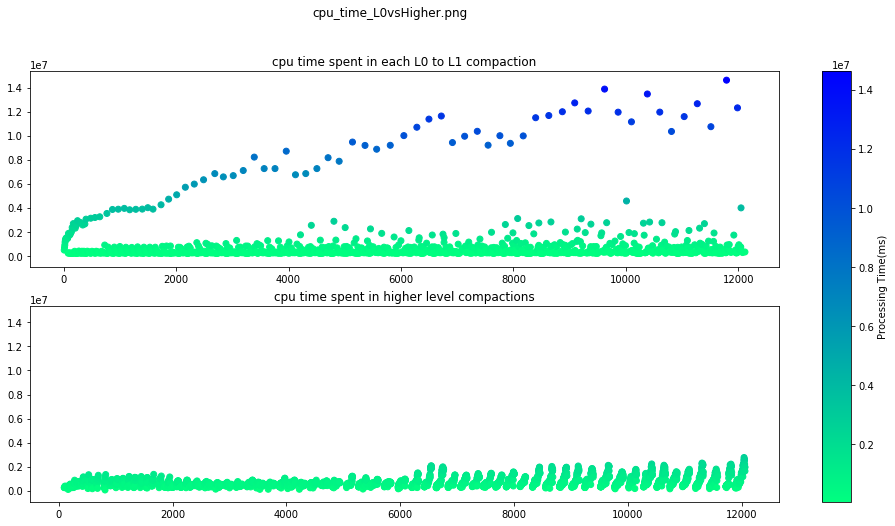

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def cpu_time_plot_single_file(result_prefix,job_dict,event_dict):
    compaction_reason_dict = {}
    compaction_latencies = []
    compaction_cpu_time = []
    # group the compaction according to the reason
    for compaction_job in job_dict['compaction_started']:    
        compaction_start_row = event_dict['compaction_started'][compaction_job][0]
        compaction_finish_row = event_dict['compaction_finished'][compaction_job][0]
        current_reason = compaction_start_row['compaction_reason']
        
        if current_reason not in compaction_reason_dict:
            compaction_reason_dict[current_reason] = []
        else:
            compaction_reason_dict[current_reason].append(compaction_job)
        compaction_latencies.append(compaction_finish_row['compaction_time_micros'])
        compaction_cpu_time.append(compaction_finish_row['compaction_time_cpu_micros'])
    reason_count = len(compaction_reason_dict.keys())
    
    fig = plt.figure(figsize=(16, 9))
    grid = plt.GridSpec(9,13,hspace=2,wspace=1.5)
    l0_compaction = fig.add_subplot(grid[0:4,1:12])
    high_level_compaction = fig.add_subplot(grid[4:8,1:12],sharey=l0_compaction)
    
    l0_compaction.set_title("cpu time spent in each L0 to L1 compaction")
    high_level_compaction.set_title("cpu time spent in higher level compactions")
    
    color_bar = fig.add_subplot(grid[:-1,-1:])
    
    # determine the color bar first
    cmap = mpl.cm.winter_r
    norm = mpl.colors.Normalize(vmin=min(compaction_cpu_time), vmax=max(compaction_cpu_time))
    
    cb1 = mpl.colorbar.ColorbarBase(color_bar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb1.set_label('Processing Time(ms)')
    
    # add data to plot
    l0_compaction_ids = compaction_reason_dict['LevelL0FilesNum']
    high_level_compaction_ids = compaction_reason_dict['LevelMaxLevelSize']
    
    l0_compaction_cpu_times = []
    high_level_compaction_cpu_times = []
    
    for id in l0_compaction_ids:
        # event_dict['compaction_finished'][id][0]['compaction_time_cpu_micros']
        l0_compaction_cpu_times.append(float(event_dict['compaction_finished'][id][0]['compaction_time_cpu_micros']))
    for id in high_level_compaction_ids:
        high_level_compaction_cpu_times.append(float(event_dict['compaction_finished'][id][0]['compaction_time_cpu_micros']))
    
    l0_compaction.scatter(l0_compaction_ids,l0_compaction_cpu_times,
                          c=l0_compaction_cpu_times,
                          cmap=cmap)
    high_level_compaction.scatter(high_level_compaction_ids,high_level_compaction_cpu_times,c=high_level_compaction_cpu_times
                                  ,cmap=cmap,norm=norm)
    fig.suptitle("cpu_time_L0vsHigher.png")
    fig.savefig(result_prefix+"cpu_time_L0vsHigher.png")
cpu_time_plot_single_file("",job_id_dict,event_row_dict)

Compare the total time spend on L0 compaction and high level compactions

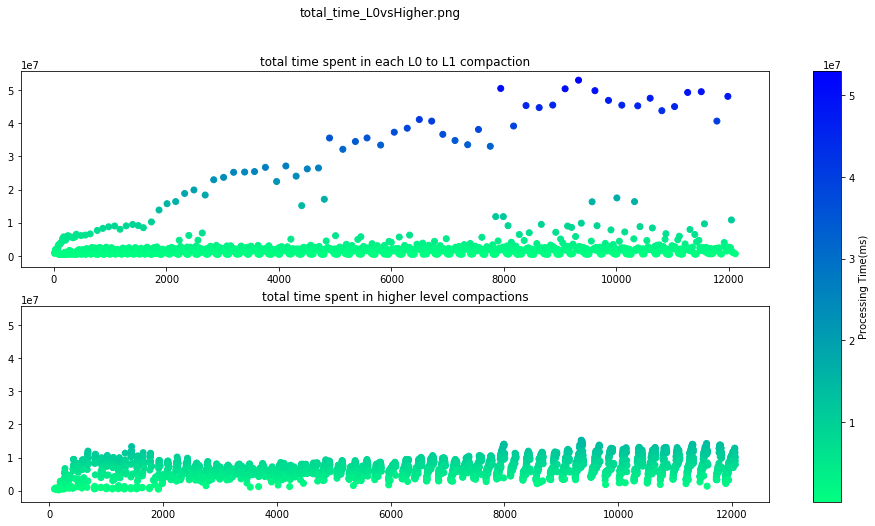

In [31]:
def total_time_plot_single_file(result_prefix,job_dict,event_dict):
    compaction_reason_dict = {}
    compaction_latencies = []
    compaction_cpu_time = []
    # group the compaction according to the reason
    for compaction_job in job_dict['compaction_started']:    
        compaction_start_row = event_dict['compaction_started'][compaction_job][0]
        compaction_finish_row = event_dict['compaction_finished'][compaction_job][0]
        current_reason = compaction_start_row['compaction_reason']
        
        if current_reason not in compaction_reason_dict:
            compaction_reason_dict[current_reason] = []
        else:
            compaction_reason_dict[current_reason].append(compaction_job)
        compaction_latencies.append(compaction_finish_row['compaction_time_micros'])
        compaction_cpu_time.append(compaction_finish_row['compaction_time_cpu_micros'])
    reason_count = len(compaction_reason_dict.keys())
    
    fig = plt.figure(figsize=(16, 9))
    grid = plt.GridSpec(9,13,hspace=2,wspace=1.5)
    l0_compaction = fig.add_subplot(grid[0:4,1:12])
    high_level_compaction = fig.add_subplot(grid[4:8,1:12],sharey=l0_compaction)
    # set the tile
    l0_compaction.set_title("total time spent in each L0 to L1 compaction")
    high_level_compaction.set_title("total time spent in higher level compactions")
    
    color_bar = fig.add_subplot(grid[:-1,-1:])
    
    # determine the color bar first
    cmap = mpl.cm.winter_r
    norm = mpl.colors.Normalize(vmin=min(compaction_latencies), vmax=max(compaction_latencies))
    
    cb1 = mpl.colorbar.ColorbarBase(color_bar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb1.set_label('Processing Time(ms)')
    
    # add data to plot
    l0_compaction_ids = compaction_reason_dict['LevelL0FilesNum']
    high_level_compaction_ids = compaction_reason_dict['LevelMaxLevelSize']
    
    l0_compaction_cpu_times = []
    high_level_compaction_cpu_times = []
    
    for id in l0_compaction_ids:
        # event_row_dict['compaction_finished'][id][0]['compaction_time_cpu_micros']
        l0_compaction_cpu_times.append(float(event_dict['compaction_finished'][id][0]['compaction_time_micros']))
    for id in high_level_compaction_ids:
        high_level_compaction_cpu_times.append(float(event_dict['compaction_finished'][id][0]['compaction_time_micros']))
    
    l0_compaction.scatter(l0_compaction_ids,l0_compaction_cpu_times,
                          c=l0_compaction_cpu_times,
                          cmap=cmap)
    high_level_compaction.scatter(high_level_compaction_ids,high_level_compaction_cpu_times,c=high_level_compaction_cpu_times
                                  ,cmap=cmap,norm=norm)
    
    fig.suptitle("total_time_L0vsHigher.png")
    fig.savefig(result_prefix+"total_time_L0vsHigher.png")
    
total_time_plot_single_file("",job_id_dict,event_row_dict)

Verify the observation from PM data, this group is to observe the changing tendency of increasing CPUs

In [ ]:
# materials = ['NVMeSSD','SATASSD','PM']
materials = ['PM']
cpu_count_array = [2,4,8]
memtable_size_array = [32]
l0configs=['default','tuned']

log_files = []

for material in materials: 
    for cpu_count in cpu_count_array: 
        for memtable_size in memtable_size_array:
            for l0config in l0configs:
                log_dir = log_file_path(memtable_size,cpu_count,
                                      "StorageMaterial."+material,l0_optimized=l0config,workload_size="45")
                log_files.append(find_log_file(log_dir))

print(log_files)


In [ ]:
for log_file in log_files:
    current_job_dict, current_event_dict = handle_single_file(log_file)
    figure_prefix = log_file.replace("/","+")
    cpu_time_plot_single_file(str(figure_prefix),current_job_dict,current_event_dict)
    total_time_plot_single_file(str(figure_prefix),current_job_dict,current_event_dict)
    # print(log_file)
    

Now, let's see the situation in NVMeSSD

In [33]:
# materials = ['NVMeSSD','SATASSD','PM']
materials = ['NVMeSSD']
cpu_count_array = [2,4,8]
memtable_size_array = [32]
l0configs=['default','tuned']

log_files = []

for material in materials: 
    for cpu_count in cpu_count_array: 
        for memtable_size in memtable_size_array:
            for l0config in l0configs:
                log_dir = log_file_path(memtable_size,cpu_count,
                                      "StorageMaterial."+material,l0_optimized=l0config,workload_size="45")
                log_files.append(find_log_file(log_dir))

print(log_files)


['Resources/45GB/default/StorageMaterial.NVMeSSD/2CPU/32MB/LOG_1460', 'Resources/45GB/tuned/StorageMaterial.NVMeSSD/2CPU/32MB/LOG_1360', 'Resources/45GB/default/StorageMaterial.NVMeSSD/4CPU/32MB/LOG_1240', 'Resources/45GB/tuned/StorageMaterial.NVMeSSD/4CPU/32MB/LOG_1240', 'Resources/45GB/default/StorageMaterial.NVMeSSD/8CPU/32MB/LOG_1230', 'Resources/45GB/tuned/StorageMaterial.NVMeSSD/8CPU/32MB/LOG_1200']


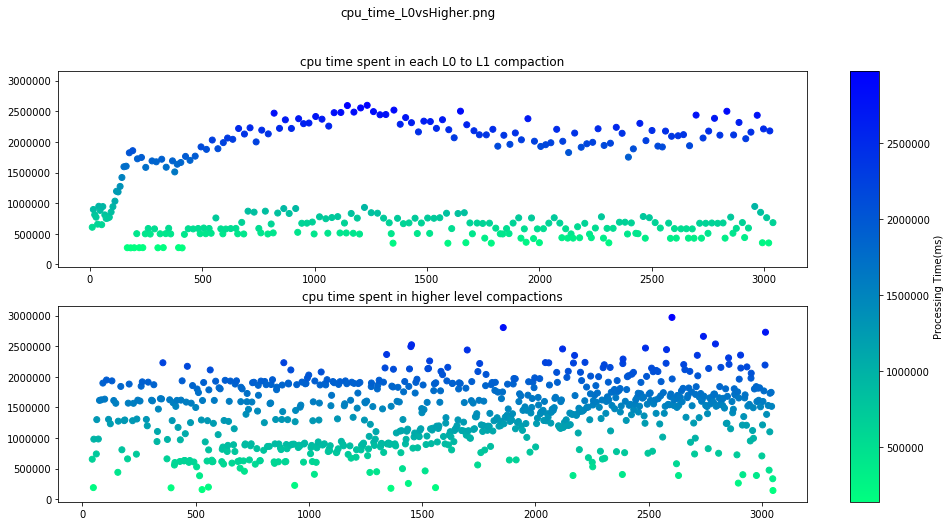

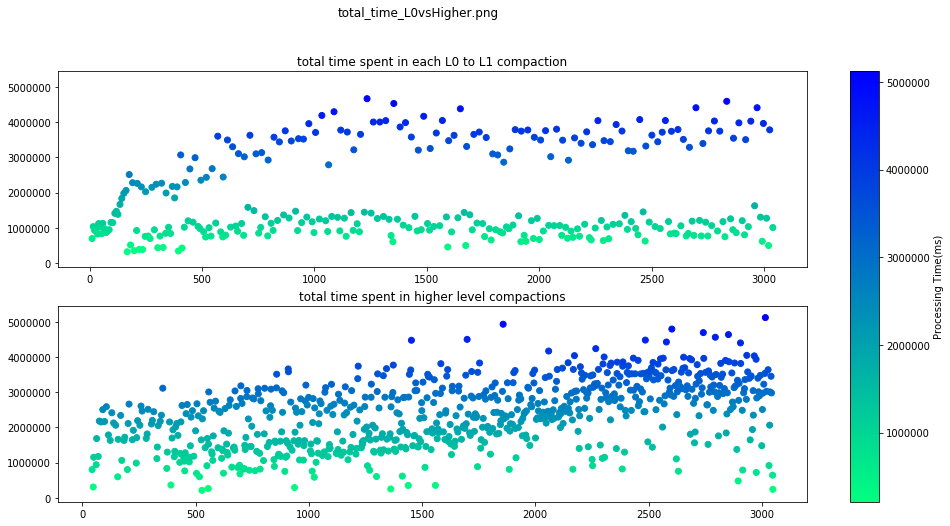

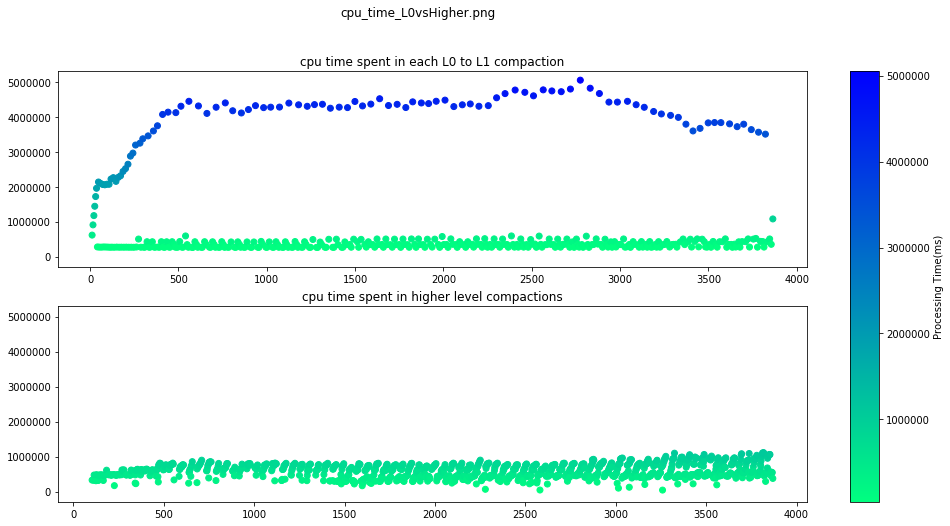

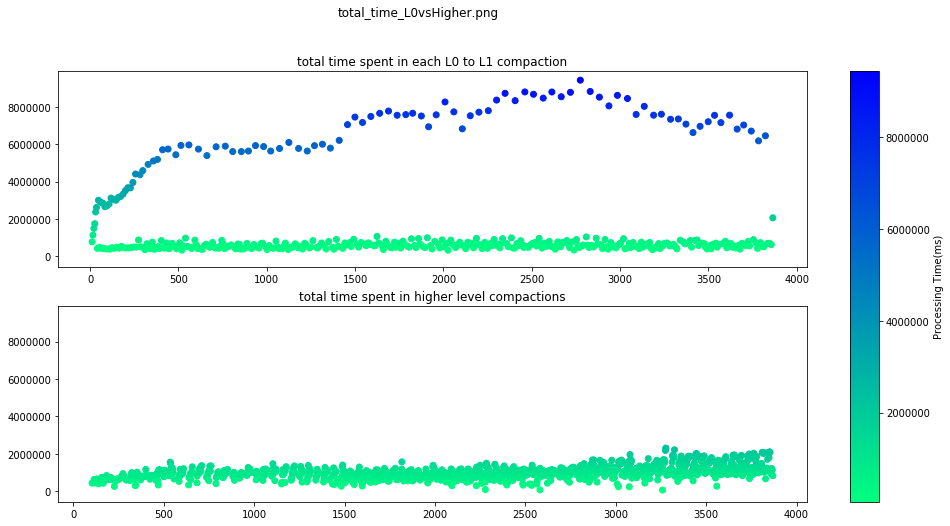

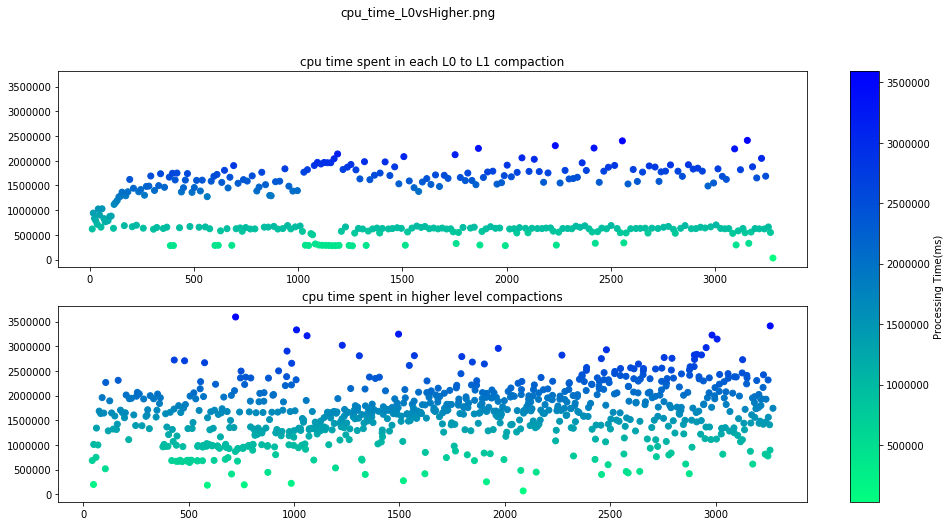

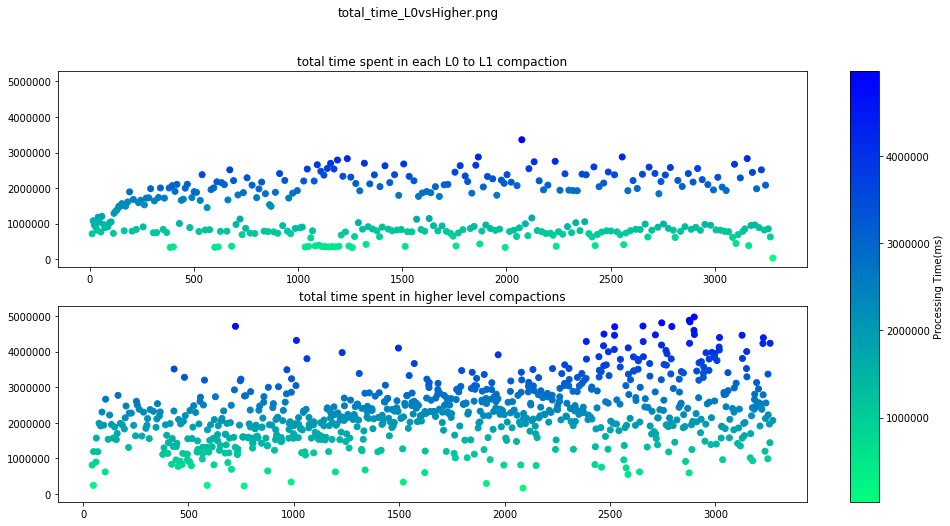

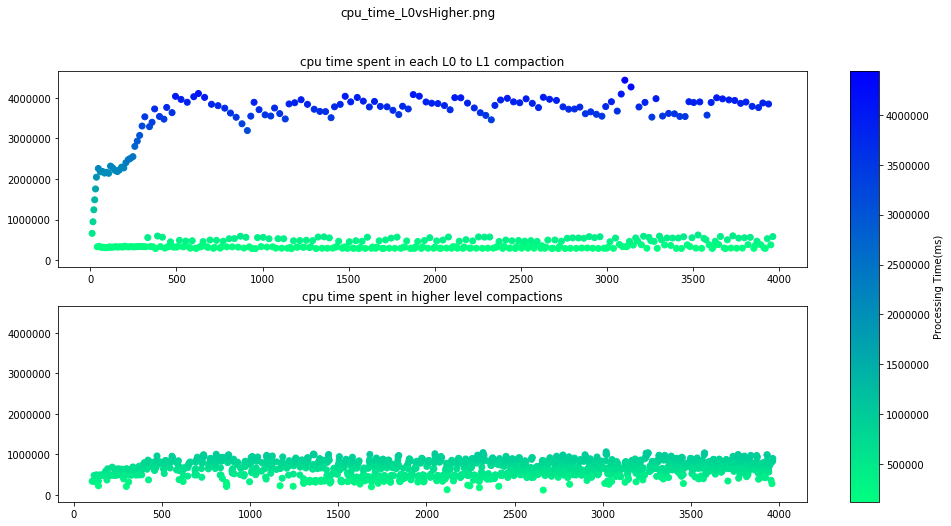

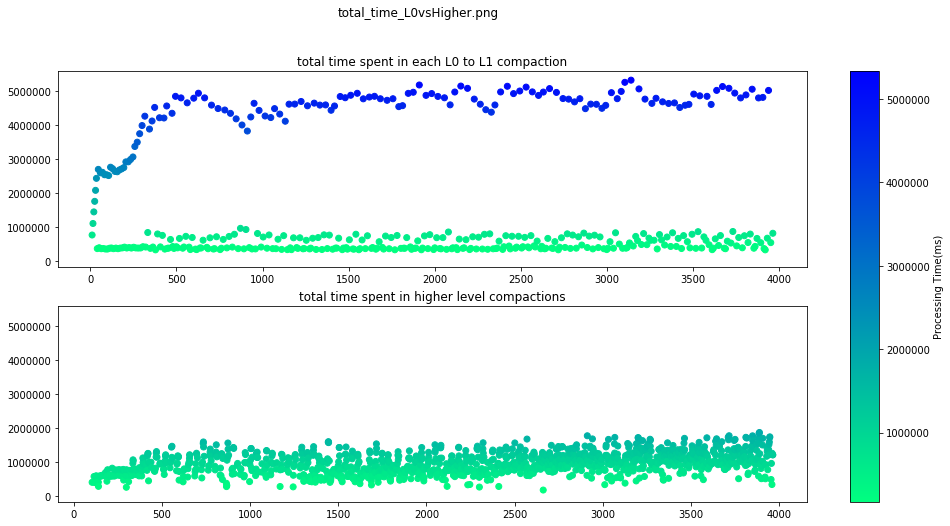

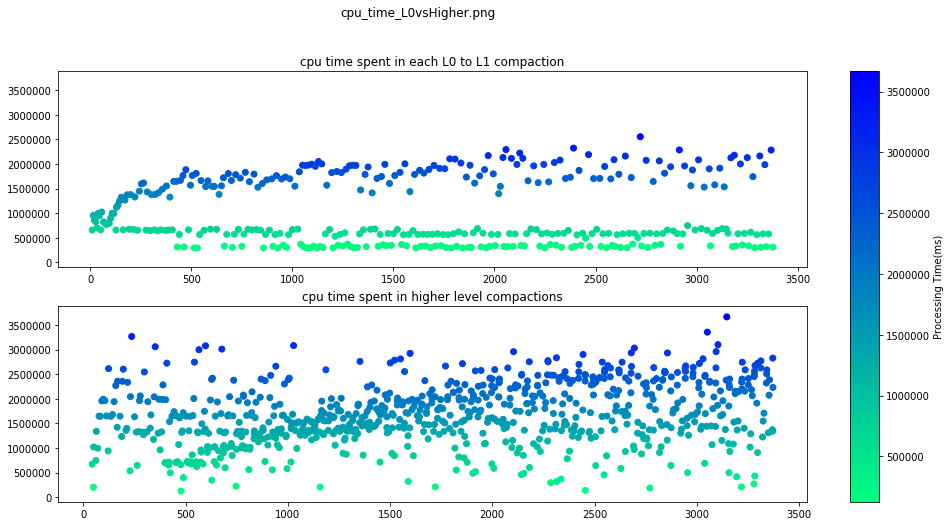

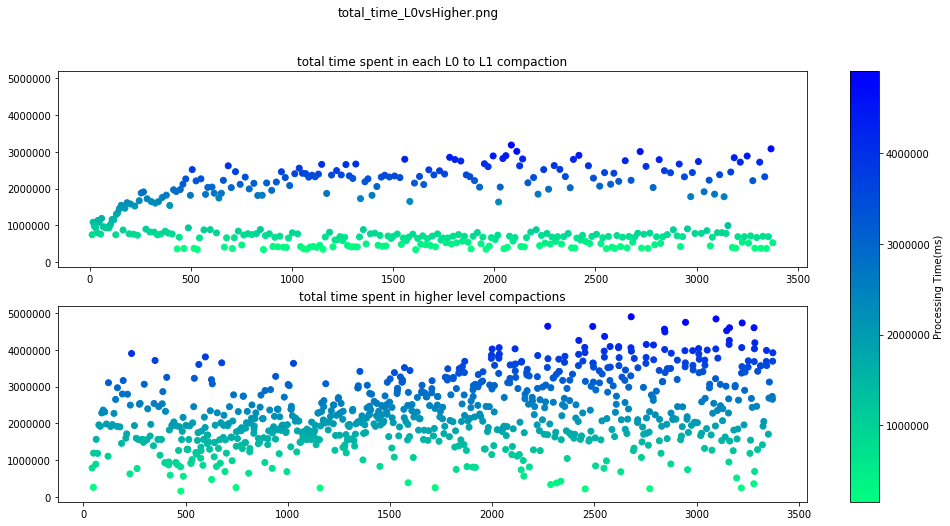

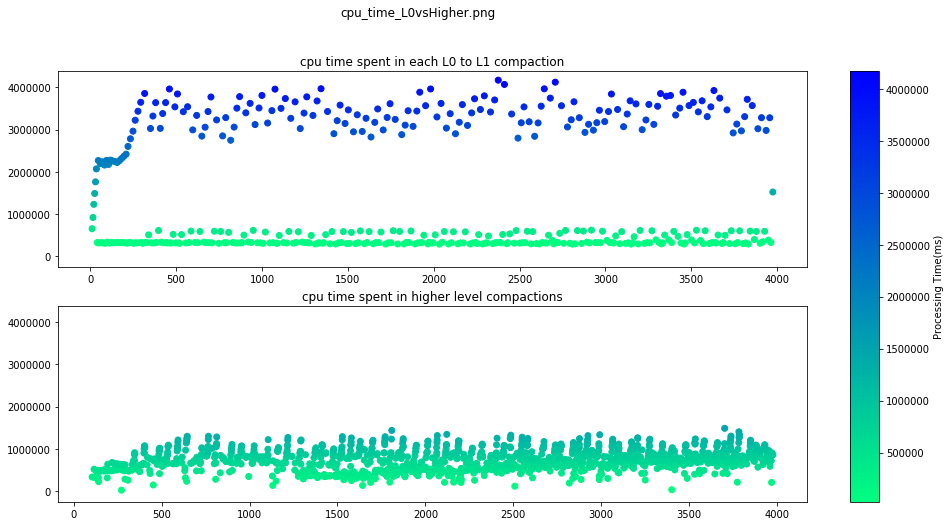

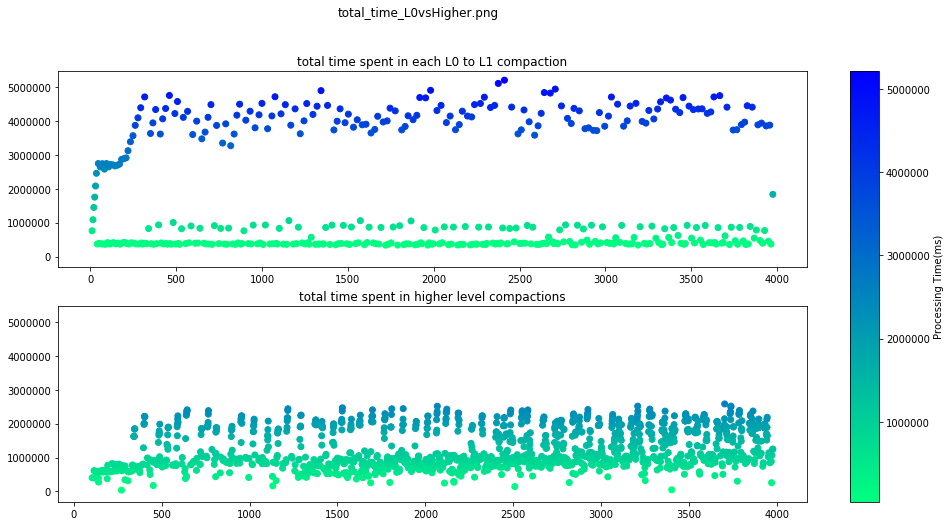

In [34]:
for log_file in log_files:
    current_job_dict, current_event_dict = handle_single_file(log_file)
    figure_prefix = log_file.replace("/","+")
    cpu_time_plot_single_file(str(figure_prefix),current_job_dict,current_event_dict)
    total_time_plot_single_file(str(figure_prefix),current_job_dict,current_event_dict)
    # print(log_file)
    